### Model selection based on metrics and human-reading

In [47]:
import pandas as pd
from plotnine import ggplot, ggtitle, geoms, aes, theme_classic, scales, theme, labels, element_blank, ylim,facet_wrap
from glob import glob
from sklearn.metrics import jaccard_score
from itertools import combinations
%matplotlib inline
import numpy as np

In [9]:
combined = pd.concat([pd.read_csv(i) for i in glob('../data/coherence/*unigram_coherence.csv')])

### Identifying optimal K using TC-W2V with entire congressional speech corpus

For each chamber of congress, the highest TC-W2V score is identified.

These are max values, but a good question is what sort of variation is there in the coherence scores really? From eyeballing the topics, there seems to be plenty of coherent topics in the higher k topic models, so how much "better" are these max values than the rest of the k topic models?

In [12]:
max_min_cngress_w2v = combined.groupby('chamber')['congress_w2v'].max().reset_index().merge(combined.groupby('chamber')['congress_w2v'].min().reset_index(),on='chamber')

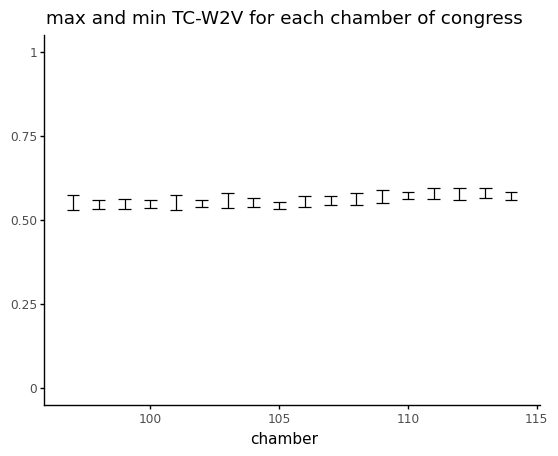

<ggplot: (-9223363291549303843)>

In [13]:
(
    ggplot(max_min_cngress_w2v,aes(x = 'chamber')) +
    geoms.geom_errorbar(aes(ymin='congress_w2v_y',ymax='congress_w2v_x')) +
    ylim(0,1) +
    theme_classic() +
    ggtitle('max and min TC-W2V for each chamber of congress')
)

#### NOTE: ultimately, there does not seem to be a meaningful amount of variation in the coherence scores over a large range

Coherence does seem to rise slightly over time, but this is also negligable

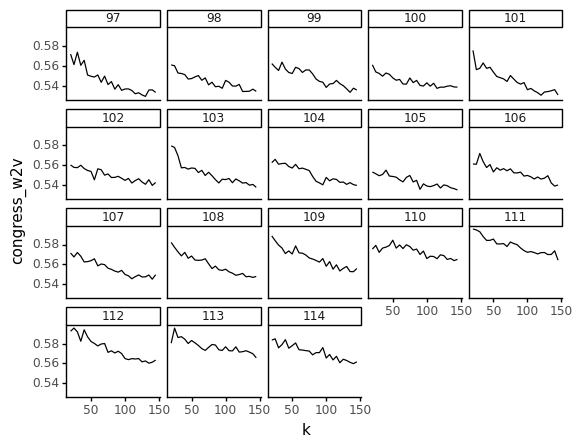

<ggplot: (-9223363291562031886)>

In [14]:
(
    ggplot(combined, aes(x = 'k',y='congress_w2v')) + 
    geoms.geom_line() +
    theme_classic() + 
    facet_wrap('~chamber') 
)

The above graph is somewhat misleading because of the scale of the y-axis. It does look like coherence decreases as k increases generally, however the amount of change in coherence is in fact quite small. At most, across all different chambers, coherence changes from around 0.58 to 0.54. This meager change in value is also relatively small compared to other studies that have used the TC-W2V method (Greene & Cross, 2017; O'Callaghan et al., 2015)

### Generalizability of topics

Another metric to consider in selecting K is topic generalizability, or the extent to which topics are distinct from one another. The more generalizable a topic model, the less likely its topics are to be distinct in their meaning. NMF is known to produce more coherent and more niche or specific topics relative to LDA (O'Callaghan 2017), and is generally measured using the pairwise Jacaard similarity between the top N terms of topic descriptions. Here I compute this value for every pairwise topic for each model and look at the mean Jacaard similarity score across k and chambers.

In [27]:
descriptions = pd.concat([pd.read_csv(i) for i in glob('../data/descriptions/*_unigram_descriptions.csv')])

In [57]:
chamber_list = []
def run_pairwise_jacaard(df):
    if df.chamber.unique()[0] not in chamber_list:
        print(df.chamber.unique()[0])
        chamber_list.append(df.chamber.unique()[0])
    mat = df.iloc[:,1:11].to_numpy()
    return np.mean([jaccard_score(combo[0],combo[1],average='macro') for combo in combinations(mat,2)])
    

In [58]:
generalizabilities = descriptions.groupby(['chamber','k']).apply(run_pairwise_jacaard)

97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114


In [65]:
gz = generalizabilities.reset_index()

In [66]:
gz.columns = ['chamber','k','jaccard']

In [68]:
max_min_cngress_w2v = gz.groupby('chamber')['jaccard'].max().reset_index().merge(gz.groupby('chamber')['jaccard'].min().reset_index(),on='chamber')

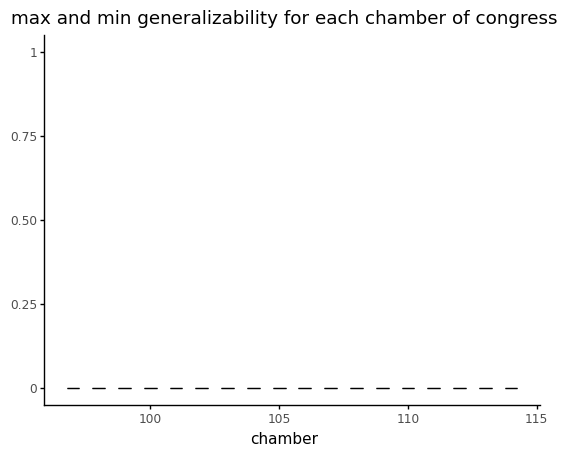

<ggplot: (8745301203162)>

In [69]:
(
    ggplot(max_min_cngress_w2v,aes(x = 'chamber')) +
    geoms.geom_errorbar(aes(ymin='jaccard_y',ymax='jaccard_x')) +
    ylim(0,1) +
    theme_classic() +
    ggtitle('max and min generalizability for each chamber of congress')
)

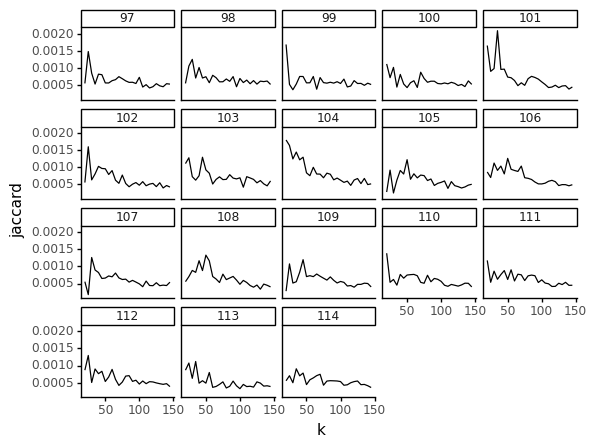

<ggplot: (-9223363291592527132)>

In [70]:
(
    ggplot(gz, aes(x = 'k',y='jaccard')) + 
    geoms.geom_line() +
    theme_classic() + 
    facet_wrap('~chamber') 
)

This analysis seems to indicate that values of k less than 50 result in more generalizable and thus less distinct topics. From this analysis and previous experience with the dataset, I am resolving to test first a DNMF with 75 topics. This is a decision made based upon my own experimenting with the data. Larger values of K seem to maintain topics found in lower values of k, but also, based on these jaccard values, seem to split up topics into more distinct and niche topics. Of course, choosing k a-priori may have drawbacks, as there may be varying numbers of topics from chamber to chamber that best capture all content, however It is my belief that this number of topics will capture all of the relevant information for each chamber while also providing coherent and distinct topics. 